# Imdb sentiment classification.

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [58]:
# Basic packages.
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Keras specific packages.
from keras import Input
from keras import Model
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, GRU
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.datasets import imdb

In [44]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.25
TEXT_DATA_DIR = "dataset/20_newsgroup"
GLOVE_DIR = "dataset/glove"
EPOCHS = 10
BATCH_SIZE = 129

## 1. Load the dataset.

In [45]:
# Load the data.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_NUM_WORDS)

In [46]:
# Get the word to index dict.
word_to_index = imdb.get_word_index()

# Get the index to word dict.
index_to_word = dict(
[(value, key) for (key, value) in word_to_index.items()])

In [47]:
# Display
print("Length dictionnary = {}".format(len(word_to_index)))

max_row = []
for i in range(x_train.shape[0]):
    max_row.append(len(x_train[i]))
print(max(max_row))

Length dictionnary = 88584
2494


## 2. Preparing the pretrained embedding layer.

In [48]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, "glove.6B.{}d.txt".format(EMBEDDING_DIM)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [49]:
embedding_matrix = np.zeros((len(word_to_index) + 1, EMBEDDING_DIM))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [50]:
embedding_layer = Embedding(len(word_to_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## 3. Handle the dataset.

Here we gather the features of words $X \in \mathbb{R}^{m \times n}$ where $m$ is the total number of samples and $n$ is the features length. For the current example $n$ is equal to $10000$.


In [51]:
# Pad the training and test features.
x_tr = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_te = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

# Display the size.
print("Size x_tr = {}".format(x_tr.shape))
print("Size x_te = {}".format(x_te.shape))

Size x_tr = (25000, 1000)
Size x_te = (25000, 1000)


In [52]:
# Handle the training and test labels.
y_tr = y_train.reshape(-1, 1)
y_te = y_test.reshape(-1, 1)

# Display the shapes.
print("y_train ", y_tr.shape)
print("y_test ", y_te.shape)

y_train  (25000, 1)
y_test  (25000, 1)


## 3. Build the model.

In [65]:
# Set the input.
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

# Set the embedding layer.
embedded_sequences = embedding_layer(sequence_input)

# Conv layer 1.
"""
x = Conv1D(64, 5, kernel_regularizer=regularizers.l2(0.001))(embedded_sequences)
x = Activation("relu")(x)
x = MaxPooling1D(5)(x)
X = Dropout(0.5)(x)

# Conv Layer 2.
x = Conv1D(64, 5, kernel_regularizer=regularizers.l2(0.001))(x)
x = Activation("relu")(x)
x = MaxPooling1D(5)(x)
X = Dropout(0.5)(x)

# Conv Layer 3.
x = Conv1D(64, 5, kernel_regularizer=regularizers.l2(0.001))(x)
x = Activation("relu")(x)
x = MaxPooling1D(35)(x)
X = Dropout(0.5)(x)

# Output layer.
x = Flatten()(x)
x = Dense(128)(x)
x = Activation("relu")(x)
X = Dropout(0.5)(x)

"""

#x = Flatten()(x)
#x = Dense(128)(x)
#x = Activation("relu")(x)
#X = Dropout(0.5)(x)

x = GRU(128, return_sequences=False)(embedded_sequences)

# Softmax layer.
preds = Dense(1, activation="sigmoid")(x)

# Build the model.
model = Model(sequence_input, preds)

# Set the optimizer.
optim = optimizers.Adam(lr=0.001)

# Compile the model.
model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["acc"])

# Set the fitting parameters.
fit_params = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "validation_split": VALIDATION_SPLIT,
    "shuffle": True
}

# Print the model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         8858500   
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 8,946,565
Trainable params: 88,065
Non-trainable params: 8,858,500
_________________________________________________________________


In [66]:
# Fit the model.
history = model.fit(x_tr, y_tr, **fit_params)

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 300s 16ms/step - loss: 0.6888 - acc: 0.5370 - val_loss: 0.6762 - val_acc: 0.5653
Epoch 2/10
 1677/18750 [=>............................] - ETA: 3:44 - loss: 0.6670 - acc: 0.5951

KeyboardInterrupt: 

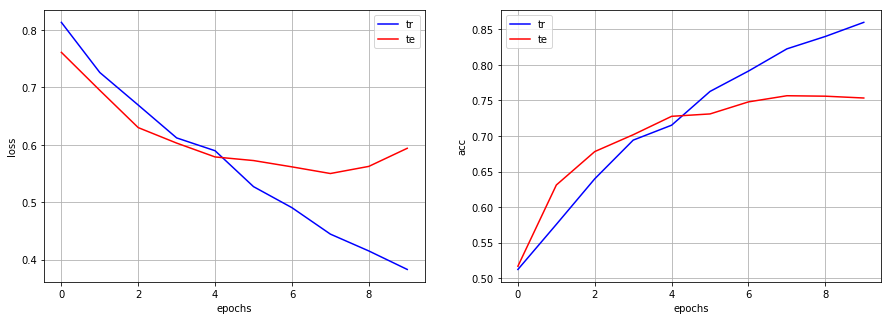

In [56]:
# Visualise the training resuls.
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history["loss"], color="b", label="tr")
plt.plot(history.history["val_loss"], color="r", label="te")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(history.history["acc"], color="b", label="tr")
plt.plot(history.history["val_acc"], color="r", label="te")
plt.ylabel("acc")
plt.xlabel("epochs")
plt.grid()
plt.legend()
plt.show()

## 4. Evaluation

In [57]:
# Get the predictions for the test dataset.
y_pred = model.predict(x_te)

# Update the predictions.
y_pred = 1.0 * (y_pred > 0.5 )

# Display the classification report.
print(classification_report(y_te, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.69      0.74     12500
          1       0.72      0.82      0.77     12500

avg / total       0.76      0.75      0.75     25000

